## Prompt Chaining 

Topic -> LLM -> Generate Outline -> LLM -> Generate final blog

In [22]:
## LLM used

from langchain_ollama import ChatOllama 

llm = ChatOllama(
    model='llama3.2',
    verbose=True,
    temperature=0.2
)

llm.invoke("Hey How are you?")

AIMessage(content="I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2026-01-05T18:38:25.49277Z', 'done': True, 'done_reason': 'stop', 'total_duration': 21775223333, 'load_duration': 1375077875, 'prompt_eval_count': 30, 'prompt_eval_duration': 17013133375, 'eval_count': 47, 'eval_duration': 3383175042, 'logprobs': None, 'model_name': 'llama3.2', 'model_provider': 'ollama'}, id='lc_run--019b8f73-b5a8-7990-82e4-5fdf28074aeb-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 30, 'output_tokens': 47, 'total_tokens': 77})

---

## Building Graph

In [23]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, List, Annotated

class ResearchState(TypedDict):
    topic: str 
    outline: List[str]
    blog_content: str 

In [24]:
# structured output validation from llm for outline
from pydantic import BaseModel, Field

class StructuredOutline(BaseModel):
    """What LLM should return when asked to generate outline related to topic"""
    outline: Annotated[List[str], Field(description="List of sections for the blog.")]

In [25]:
from langchain_core.prompts import PromptTemplate 

def llm_generate_outline(state: ResearchState) -> ResearchState:
    template = """ 
                Given a topic of blog : {topic}, you need to generate a list of sections that should be put in blog related to that topic.
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['topic']
    )

    llm_outline = llm.with_structured_output(StructuredOutline)

    chain = prompt | llm_outline 
    
    response = chain.invoke({'topic' : state['topic']})
    state['outline'] = response.outline
    return state

def llm_generate_blog(state: ResearchState) -> ResearchState:
    template = """ 
                Given a topic of blog : {topic}, and sections to be include : {outline}.
                Generate content of the blog.
               """
    
    prompt = PromptTemplate(
        template=template,
        input_variables=['topic', 'outline']
    )

    chain = prompt | llm 

    response = chain.invoke({'topic' : state['topic'], 'outline' : state['outline']})
    state['blog_content'] = response.content
    return state

    

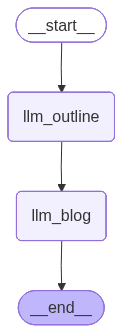

In [26]:
graph = StateGraph(ResearchState)

# add nodes
graph.add_node('llm_outline', llm_generate_outline)
graph.add_node('llm_blog', llm_generate_blog)

# add edges 
graph.add_edge(START, 'llm_outline')
graph.add_edge('llm_outline', 'llm_blog')
graph.add_edge('llm_blog', END)

# compile graph 
prompt_sequencing = graph.compile()

# show graph 
# display the graph 
from IPython.display import Image 
Image(prompt_sequencing.get_graph().draw_mermaid_png())

In [27]:
# executing 
output = prompt_sequencing.invoke({'topic' : "Transformers"})
print(output)

{'topic': 'Transformers', 'outline': ['Introduction', 'History of Transformers', 'Types of Transformers', 'Applications of Transformers', 'Advantages and Disadvantages', 'Safety Precautions', 'Future of Transformers'], 'blog_content': "**Transformers: The Powerhouses of Modern Industry**\n\nTransformers have revolutionized the way we live, work, and interact with technology. From powering homes to transmitting data across vast distances, these incredible machines have become an integral part of our daily lives. In this blog, we'll delve into the world of transformers, exploring their history, types, applications, advantages, disadvantages, safety precautions, and the future of these powerhouses.\n\n**Introduction**\n\nA transformer is a device that transfers electrical energy from one circuit to another through electromagnetic induction. It consists of two coils of wire, known as the primary and secondary coils, which are connected to a power source. When an alternating current (AC) fl